In [41]:
import altair as alt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [102]:
def read_experiment_data(exp_folder: Path):
    data = []
    files = sorted(list(map(lambda x: (int(x.name.split('_')[1].split('.')[0]), x), list(exp_folder.glob('*.csv')))))

    for dist, file in files:
        df = pd.read_csv(file, header=None)
        for _, (t, v, us) in df.iterrows():
            data.append((t, dist, 1/v, us))
    df = pd.DataFrame(data, columns=["t", "dist", "IR", 'Ultrasound'])
    return df
            
df_1 = read_experiment_data(Path('exp_1/'))
df_2 = read_experiment_data(Path('exp_2/'))
df = pd.concat([df_1, df_2])

In [103]:
def visualize_results(df, sensor):
    return (alt.Chart(df).encode(
        x=alt.X('dist:Q', title='Distance, cm'),
        y=alt.Y(f'min({sensor}):Q', scale=alt.Scale(zero=False), title='Boxplot, mV' if sensor == 'IR' else 'Boxplot, cm'),
        y2=f'max({sensor}):Q',
        tooltip=['dist', f'min({sensor})', f'max({sensor})']
    ).mark_rule() + alt.Chart(df).encode(
        x='dist:Q',
        y=f'median({sensor}):Q',
        tooltip=['dist', f'min({sensor})', f'max({sensor})']
    ).mark_point(size=1)).properties(
        title=f'Correspondence between distance and {sensor} measurements'
    )

In [108]:
(
    (visualize_results(df_1, 'IR') | visualize_results(df_2, 'IR'))
    &
    (visualize_results(df_1, 'Ultrasound') | visualize_results(df_2, 'Ultrasound'))
)

alt.VConcatChart(...)

For infrared sensor, the fitting can be done. Ultrasound can compared exactly

In [160]:
dist = df_1.groupby('dist').mean().reset_index()['dist'].values
mv = df_1.groupby('dist').mean().reset_index()['IR'].values

a,b = np.polyfit(np.log(dist), np.log(mv), deg=1)

pred_mv = np.exp(b + a*np.log(dist))

np.exp((np.log(mv) - b)/a)

int_df = pd.DataFrame({'dist': dist, 'mv_orig': mv, 'mv_fitted': pred_mv})
int_df = pd.wide_to_long(int_df, stubnames='mv', i=['dist'], j='mV_type', sep='_', suffix=r'\w+').reset_index()
alt.Chart(int_df).encode(
    x=alt.X('dist', title='Distance, cm'),
    y=alt.Y('mv:Q', scale=alt.Scale(zero=False), title='mV'),
    color='mV_type'
).mark_line().properties(title='Comparison between IR values and exponential fitting')

/opt/homebrew/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [109]:
train_df = read_experiment_data(Path('exp_1/'))
train_df = df_1[df_1.dist > 10]
train_df['diff'] = train_df['dist'] - train_df['Ultrasound']

/var/folders/4k/g9fmxr415sb_6r09m23q8p8m0000gn/T/ipykernel_46025/1229782273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['diff'] = train_df['dist'] - train_df['Ultrasound']


alt.LayerChart(...)

In [78]:
df = pd.DataFrame(data, columns=["t", "dist", "IR", 'Ultrasound'])
df['diff'] = df['dist'] - df['Ultrasound']

In [163]:
df

,t,dist,IR,Ultrasound
0,0.0,2,0.041667,2.62
1,602.0,2,0.043478,2.61
2,1205.0,2,0.041667,2.61
3,1808.0,2,0.041667,2.61
4,2411.0,2,0.041667,2.62
...,...,...,...,...
2011,1431.0,265,0.002849,261.33
2012,2050.0,265,0.002849,261.78
2013,2668.0,265,0.002849,261.78
2014,6569.0,265,0.002857,261.37


In [79]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_df['dist'].values.reshape(-1, 1), train_df['diff'].values)

LinearRegression()

In [80]:
diff_pred = model.predict(df['dist'].values.reshape(-1, 1))
df['diff_calibrated'] =  df['Ultrasound'] + diff_pred - df['dist']

In [81]:
def get_error_chart(sensor):
    return (alt.Chart(df).encode(
        x=alt.X('dist:Q', title='Distance, cm'),
        y=alt.Y(f'min({sensor}):Q', scale=alt.Scale(zero=False, domainMin=-5, clamp=True), title='Boxplot, mV' if sensor == 'IR' else 'Boxplot, cm'),
        y2=f'max({sensor}):Q',
        tooltip=['dist', f'min({sensor})', f'max({sensor})']
    ).mark_rule() + alt.Chart(df).encode(
        x='dist:Q',
        y=alt.Y(f'median({sensor}):Q', scale=alt.Scale(zero=False, domainMin=-5, domainMax=10, clamp=True), title='Boxplot, cm'),
        tooltip=['dist', f'min({sensor})', f'max({sensor})']
    ).mark_point(size=1)).properties(
        title=f'Error rate between Ultrasound and reference'
    )
    
get_error_chart('diff') | get_error_chart('diff_calibrated')

/opt/homebrew/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

In [97]:
# dist, mv, _ = list(zip(*data))
# np.poly


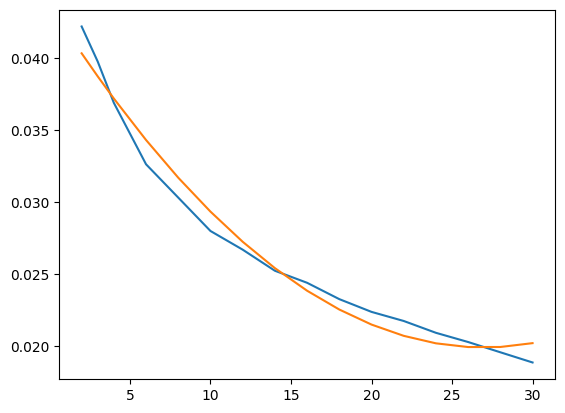

In [98]:
coeff = np.polyfit(dist, mv, deg=2)

plt.plot(dist, mv)
plt.plot(dist, np.polyval(coeff, dist))

-0.30356696461960136 -2.894022795773058


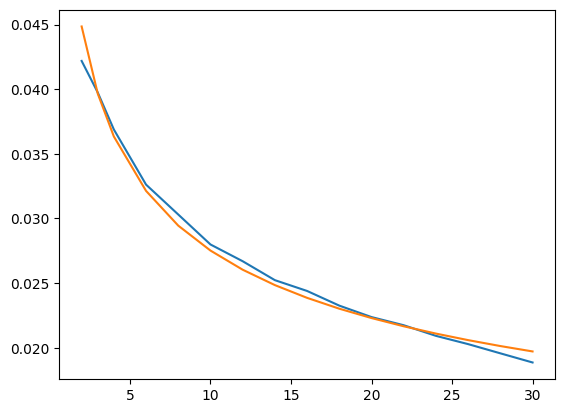